In [1]:
!nvidia-smi

Sun Aug 13 19:16:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8     8W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from tqdm.notebook import tqdm

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from PyPDF2 import PdfReader

In [3]:
print(torch.__version__)

# set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device     

2.0.1


'cuda'

# 1. Find and Download the Dataset:

### * Find and download the dataset from

https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset

If you use any other dataset, make sure the dataset has a CSV file containing Resume's text and domain (e.g., sales, marketing) for this code to work.

In [4]:
# Set the location of CSV file containing Resume's text and category to csv_location

csv_location = './resume-dataset/Resume/Resume.csv'

In [5]:
# load the csv file with pandas dataframe

df = pd.read_csv(csv_location)
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


The CSV file must have columns named "text" and "category" for this code. If you are using any other dataset, the CSV columns might be named differently. In this case, you need to rename it using the code below. Modify the code manually otherwise the code might fail to run. 

In [6]:
# Drop the unnecessary columns. We dont need "Resume_html" column.

df = df.drop(columns=['Resume_html'])

# Renaming columns to text and category

df = df.rename(columns={"Resume_str": "text", "Category":"category"}, errors="raise")
df.head()

,ID,text,category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


# 2. Data Exploration and Preprocessing:

### * Examine the dataset provided and understand the distribution of the different categories

<Axes: xlabel='count', ylabel='category'>

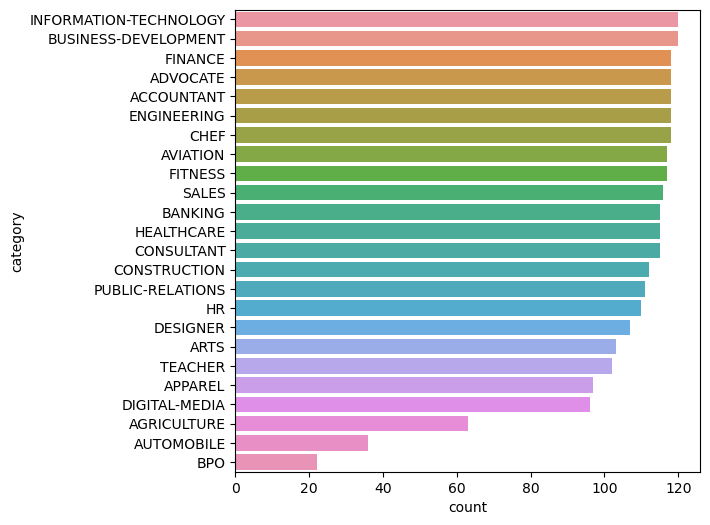

In [7]:
# let's visulize the distribution of the different categories.

plt.figure(figsize=(6,6))
sns.countplot(y="category", data=df, order=df['category'].value_counts().index)

This dataset is not ideal for this code as it is unbalanced. The model might perform poorly to classify categories with fewer data (such as AGRICULTURE, AUTOMOBILE, BPO)

In [8]:
# lets check value types of different columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        2484 non-null   int64 
 1   text      2484 non-null   object
 2   category  2484 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.3+ KB


Since our category column's data type is "object" we need to convert it into numbers for our deep learning models.

In [9]:
# find the possible labels in the category column

possible_labels = df.category.unique()

# Create a dictionary of category values as keys, and numbers as values.

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'HR': 0,
 'DESIGNER': 1,
 'INFORMATION-TECHNOLOGY': 2,
 'TEACHER': 3,
 'ADVOCATE': 4,
 'BUSINESS-DEVELOPMENT': 5,
 'HEALTHCARE': 6,
 'FITNESS': 7,
 'AGRICULTURE': 8,
 'BPO': 9,
 'SALES': 10,
 'CONSULTANT': 11,
 'DIGITAL-MEDIA': 12,
 'AUTOMOBILE': 13,
 'CHEF': 14,
 'FINANCE': 15,
 'APPAREL': 16,
 'ENGINEERING': 17,
 'ACCOUNTANT': 18,
 'CONSTRUCTION': 19,
 'PUBLIC-RELATIONS': 20,
 'BANKING': 21,
 'ARTS': 22,
 'AVIATION': 23}

In [10]:
# Now add the corresponding category values to a new column "label" in dataframe.

df['label'] = df.category.replace(label_dict)
df.head()

,ID,text,category,label
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,0
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,0
2,33176873,HR DIRECTOR Summary Over 2...,HR,0
3,27018550,HR SPECIALIST Summary Dedica...,HR,0
4,17812897,HR MANAGER Skill Highlights ...,HR,0


### * Split the dataset into training, validation, and test sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                    df.label.values, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=df.label.values
                                                   )

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=42,
                                                  stratify=y_train) # 0.25 x 0.8 = 0.2

print("train, test, validation --- \n", 
      X_train.shape, X_test.shape, X_val.shape, "\n", y_train.shape, y_test.shape, y_val.shape)

train, test, validation --- 
 (1490,) (497,) (497,) 
 (1490,) (497,) (497,)


In [12]:
# Lets add a new column "data_type", indicating which data split it belongs to

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

df['data_type'].unique()

array(['train', 'test', 'val'], dtype=object)

In [13]:
# lets check the split distribution of each category

pd.set_option('display.max_rows', None)
df.groupby(['category', 'label', 'data_type']).count()

ID  text
category               label data_type          
ACCOUNTANT             18    test       24    24
                             train      70    70
                             val        24    24
ADVOCATE               4     test       24    24
                             train      70    70
                             val        24    24
AGRICULTURE            8     test       13    13
                             train      38    38
                             val        12    12
APPAREL                16    test       19    19
                             train      59    59
                             val        19    19
ARTS                   22    test       21    21
                             train      62    62
                             val        20    20
AUTOMOBILE             13    test        7     7
                             train      22    22
                             val         7     7
AVIATION               23    test       23    23
                             train      70    70
                             val        24    24
BANKING                21    test       23    23
                             train      69    69
                             val        23    23
BPO                    9     test        4     4
                             train      14    14
                             val         4     4
BUSINESS-DEVELOPMENT   5     test       24    24
                             train      72    72
                             val        24    24
CHEF                   14    test       24    24
                             train      70    70
                             val        24    24
CONSTRUCTION           19    test       22    22
                             train      67    67
                             val        23    23
CONSULTANT             11    test       23    23
                             train      69    69
                             val        23    23
DESIGNER               1     test       21    21
                             train      64    64
                             val        22    22
DIGITAL-MEDIA          12    test       19    19
                             train      58    58
                             val        19    19
ENGINEERING            17    test       24    24
                             train      70    70
                             val        24    24
FINANCE                15    test       24    24
                             train      70    70
                             val        24    24
FITNESS                7     test       24    24
                             train      70    70
                             val        23    23
HEALTHCARE             6     test       23    23
                             train      69    69
                             val        23    23
HR                     0     test       22    22
                             train      66    66
                             val        22    22
INFORMATION-TECHNOLOGY 2     test       24    24
                             train      72    72
                             val        24    24
PUBLIC-RELATIONS       20    test       22    22
                             train      67    67
                             val        22    22
SALES                  10    test       23    23
                             train      70    70
                             val        23    23
TEACHER                3     test       20    20
                             train      62    62
                             val        20    20

Now, we should copy the test resume data into a separate folder to use the folder directory to categorize the resumes later.

In [14]:
# create a new test dataframe that contains only the test resumes' columns

test_df = df.loc[df['data_type'] == 'test', ['ID','category']]
test_df.info(), test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 1 to 2469
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        497 non-null    int64 
 1   category  497 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


(None,
           ID category
 1   22323967       HR
 2   33176873       HR
 20  30163002       HR
 21  18827609       HR
 23  12786012       HR)

In [15]:
# crate a for loop to automatically copy the test data into a separate folder

for i in test_df.values:
    
    file_name = str(i[0])
    folder_name = str(i[1])
    
    # Specify the source file path
    source_file = './resume-dataset/data/data/'+ folder_name + '/' + file_name + '.pdf'
#     print(source_file)

    # Specify the destination directory path
    destination_directory = './resume-dataset/data/test-data/' + folder_name + '/' + file_name + '.pdf'
    print(destination_directory)

    # Copy the file to the destination directory
    os.makedirs(os.path.dirname(destination_directory), exist_ok=True)
    shutil.copy(source_file, destination_directory)

./resume-dataset/data/test-data/HR/22323967.pdf
./resume-dataset/data/test-data/HR/33176873.pdf
./resume-dataset/data/test-data/HR/30163002.pdf
./resume-dataset/data/test-data/HR/18827609.pdf
./resume-dataset/data/test-data/HR/12786012.pdf
./resume-dataset/data/test-data/HR/19717385.pdf
./resume-dataset/data/test-data/HR/21265194.pdf
./resume-dataset/data/test-data/HR/72231872.pdf
./resume-dataset/data/test-data/HR/27523575.pdf
./resume-dataset/data/test-data/HR/39081840.pdf
./resume-dataset/data/test-data/HR/29564653.pdf
./resume-dataset/data/test-data/HR/14640322.pdf
./resume-dataset/data/test-data/HR/28808263.pdf
./resume-dataset/data/test-data/HR/11698189.pdf
./resume-dataset/data/test-data/HR/18557164.pdf
./resume-dataset/data/test-data/HR/19179079.pdf
./resume-dataset/data/test-data/HR/20806155.pdf
./resume-dataset/data/test-data/HR/19336728.pdf
./resume-dataset/data/test-data/HR/10694288.pdf
./resume-dataset/data/test-data/HR/10399912.pdf
./resume-dataset/data/test-data/HR/30563

./resume-dataset/data/test-data/FITNESS/12019284.pdf
./resume-dataset/data/test-data/FITNESS/24251588.pdf
./resume-dataset/data/test-data/FITNESS/22855060.pdf
./resume-dataset/data/test-data/FITNESS/19774173.pdf
./resume-dataset/data/test-data/FITNESS/29573698.pdf
./resume-dataset/data/test-data/FITNESS/95769832.pdf
./resume-dataset/data/test-data/FITNESS/89858892.pdf
./resume-dataset/data/test-data/FITNESS/25507648.pdf
./resume-dataset/data/test-data/FITNESS/17915015.pdf
./resume-dataset/data/test-data/FITNESS/16474898.pdf
./resume-dataset/data/test-data/FITNESS/69666645.pdf
./resume-dataset/data/test-data/FITNESS/76530505.pdf
./resume-dataset/data/test-data/FITNESS/77266989.pdf
./resume-dataset/data/test-data/FITNESS/27397245.pdf
./resume-dataset/data/test-data/FITNESS/10969918.pdf
./resume-dataset/data/test-data/FITNESS/57575888.pdf
./resume-dataset/data/test-data/FITNESS/96761538.pdf
./resume-dataset/data/test-data/FITNESS/14515954.pdf
./resume-dataset/data/test-data/FITNESS/341511

./resume-dataset/data/test-data/FINANCE/59450123.pdf
./resume-dataset/data/test-data/APPAREL/71767359.pdf
./resume-dataset/data/test-data/APPAREL/11677077.pdf
./resume-dataset/data/test-data/APPAREL/50324968.pdf
./resume-dataset/data/test-data/APPAREL/19070271.pdf
./resume-dataset/data/test-data/APPAREL/56151548.pdf
./resume-dataset/data/test-data/APPAREL/27099856.pdf
./resume-dataset/data/test-data/APPAREL/27549075.pdf
./resume-dataset/data/test-data/APPAREL/11232471.pdf
./resume-dataset/data/test-data/APPAREL/16723524.pdf
./resume-dataset/data/test-data/APPAREL/29640922.pdf
./resume-dataset/data/test-data/APPAREL/29028935.pdf
./resume-dataset/data/test-data/APPAREL/26586477.pdf
./resume-dataset/data/test-data/APPAREL/37750854.pdf
./resume-dataset/data/test-data/APPAREL/54308684.pdf
./resume-dataset/data/test-data/APPAREL/21570485.pdf
./resume-dataset/data/test-data/APPAREL/31761591.pdf
./resume-dataset/data/test-data/APPAREL/24516163.pdf
./resume-dataset/data/test-data/APPAREL/249898

./resume-dataset/data/test-data/AVIATION/68216398.pdf
./resume-dataset/data/test-data/AVIATION/92283635.pdf
./resume-dataset/data/test-data/AVIATION/11614114.pdf
./resume-dataset/data/test-data/AVIATION/10567764.pdf
./resume-dataset/data/test-data/AVIATION/19284293.pdf
./resume-dataset/data/test-data/AVIATION/23464505.pdf
./resume-dataset/data/test-data/AVIATION/29595906.pdf
./resume-dataset/data/test-data/AVIATION/77626587.pdf
./resume-dataset/data/test-data/AVIATION/33627938.pdf


### * Process the resumes to convert them into a format suitable for training

In [16]:
# tokenization using BertTokenizer. 
# More info https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertTokenizer.from_pretrained.example

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True);

In [17]:
# tokenization train, text, val data. 
# More info https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.encode

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    truncation=True,
    max_length=256, 
    return_tensors='pt'
)


encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    truncation=True,
    max_length=256, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length',
    truncation=True,
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values)


In [18]:
# Create tensor train, validatation, test dataset 

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

len(dataset_train), len(dataset_val), len(dataset_test)

(1490, 497, 497)

# 3. Model Selection and Training:

### * Select a suitable deep learning model.

The BERT model was proposed in BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova (https://arxiv.org/abs/1810.04805). It’s a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.

In [19]:
# Load BERT Model
# More info https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
# Create Train, test, validation dataloader

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

dataloader_test = DataLoader(dataset_test, 
                             sampler=SequentialSampler(dataset_test), 
                             batch_size=batch_size)

In [21]:
# Set model optimization
# get_linear_schedule_with_warmup creates a schedule with a learning rate that decreases linearly after linearly increasing during a warm-up period
# More info https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.get_linear_schedule_with_warmup


optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

epochs = 10 # Set a suitable epochs number

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [22]:
# Define evaluation metric for training

def score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_recall_fscore_support(labels_flat, preds_flat, average='weighted', zero_division=0)

In [23]:
# Set random seed value

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [24]:
# define evaluation funcion for model training

def evaluate(dataloader):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

### * Implement and train the model using the training set.
### * Evaluate the model's performance using the validation set

In [25]:
# Train Model

best_loss = 10

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    
    val_score = score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Precision, Recall, F1score, Support: {val_score}')
    
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Saving best model for epoch: {epoch}")
        torch.save(model.state_dict(), './finetuned_BERT.model')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.7594973669205634
Validation loss: 1.9214494591017803
Precision, Recall, F1score, Support: (0.6818679094278329, 0.6659959758551308, 0.6147925249947731, None)
Saving best model for epoch: 1


Epoch 2:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.5233878671403382
Validation loss: 1.1204345114080303
Precision, Recall, F1score, Support: (0.7778512020208074, 0.7867203219315896, 0.7593642173840763, None)
Saving best model for epoch: 2


Epoch 3:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9116284014953214
Validation loss: 0.9125177215739905
Precision, Recall, F1score, Support: (0.7981125190775196, 0.8088531187122736, 0.7908241726266916, None)
Saving best model for epoch: 3


Epoch 4:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6358898243748806
Validation loss: 0.892260230673724
Precision, Recall, F1score, Support: (0.7968471714329469, 0.806841046277666, 0.7920599870783408, None)
Saving best model for epoch: 4


Epoch 5:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.49043054557527216
Validation loss: 0.8952180227960449
Precision, Recall, F1score, Support: (0.7866755626631824, 0.8008048289738431, 0.7873094097087825, None)


Epoch 6:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.4032914689076798
Validation loss: 0.9184069036034844
Precision, Recall, F1score, Support: (0.7989181233201879, 0.8128772635814889, 0.800325019517658, None)


Epoch 7:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.3385253375456097
Validation loss: 0.9316231133865125
Precision, Recall, F1score, Support: (0.8022324378544308, 0.8128772635814889, 0.8008202379017678, None)


Epoch 8:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.3153016924562019
Validation loss: 0.9481405523459775
Precision, Recall, F1score, Support: (0.8022158121462644, 0.8148893360160966, 0.8044081077249414, None)


Epoch 9:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.2646738907296053
Validation loss: 0.961567171083494
Precision, Recall, F1score, Support: (0.8115546499690494, 0.8128772635814889, 0.8050882254731957, None)


Epoch 10:   0%|          | 0/497 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.2344420327630711
Validation loss: 0.9656974443021309
Precision, Recall, F1score, Support: (0.8065868194960139, 0.8148893360160966, 0.8058256211270629, None)


# 4. Script Development:

In [26]:
%%writefile script.py

import sys
import os
import shutil
import pandas as pd
from PyPDF2 import PdfReader
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import logging
logging.set_verbosity_error()

catogory_name = {0: 'HR', 1: 'DESIGNER', 2: 'INFORMATION-TECHNOLOGY', 3: 'TEACHER', 
                 4: 'ADVOCATE', 5: 'BUSINESS-DEVELOPMENT', 6: 'HEALTHCARE', 7: 'FITNESS', 
                 8: 'AGRICULTURE', 9: 'BPO', 10: 'SALES', 11: 'CONSULTANT', 12: 'DIGITAL-MEDIA', 
                 13: 'AUTOMOBILE', 14: 'CHEF', 15: 'FINANCE', 16: 'APPAREL', 17: 'ENGINEERING', 
                 18: 'ACCOUNTANT', 19: 'CONSTRUCTION', 20: 'PUBLIC-RELATIONS', 21: 'BANKING', 
                 22: 'ARTS', 23: 'AVIATION'}

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True);

device = "cuda" if torch.cuda.is_available() else "cpu"

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(catogory_name),
                                                      output_attentions=False,
                                                      output_hidden_states=False).to(device);

model.load_state_dict(torch.load('./finetuned_BERT.model', map_location=torch.device(device)))
   

    
# category prediction function
def categorize(text):
    
    # tokenize the resume's text
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True, 
        return_attention_mask=True, 
        padding='max_length', 
        truncation=True,
        max_length=256, 
        return_tensors='pt'
    )
    
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)
    
    # predict with model
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        prediction = torch.argmax(output[0], dim=1).cpu().numpy()
    
    return catogory_name[prediction[0]]



# functions to move files to predicted categories
def action(directory):

    
    file_names = []
    labels = []

    # iterate over the directory to get resumes' information
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.pdf'):
                file_path = os.path.join(root, file).replace('\\', '/')
                print('- Found resume location at',file_path)
                if os.path.isfile(file_path):
                    file_name = file_path.split('/')[-1].split('.')[0]
                    file_names.append(file_name)
                    pdf_reader = PdfReader(file_path)

            text = ''        
            for i in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[i]
                text += page.extract_text()
            
            cat_name = categorize(text)
            labels.append(cat_name)

            source_file = file_path
            destination_directory = './resume-categories-predicted/' + cat_name +'/'
            print(f'Copied "{file_name}" resume to the category folder destination "{destination_directory}"')

            os.makedirs(os.path.dirname(destination_directory), exist_ok=True)
            shutil.copy(source_file, destination_directory)

    csv_df = pd.DataFrame({'filename' : file_names, 'category': labels})
    csv_df.to_csv('./categorized_resumes.csv')
    print('> CSV file created at current location')

    

def main():
    args = sys.argv[1:]
    dir_path = args[0]
#     dir_path = './resume-dataset/data/test-data'
    action(dir_path)
    
    
if __name__ == '__main__':
    main()

Writing script.py


# 5. Command Line Execution:

Jupyter Notebook can do command line execution directly from here. However, to manually run from the command prompt/terminal make sure you have the required packages installed in your device.

In [27]:
!python script.py ./resume-dataset/data/test-data/

- Found resume location at ./resume-dataset/data/test-data/ACCOUNTANT/10674770.pdf
Copied "10674770" resume to the category folder destination "./resume-categories-predicted/ACCOUNTANT/"
- Found resume location at ./resume-dataset/data/test-data/ACCOUNTANT/11759079.pdf
Copied "11759079" resume to the category folder destination "./resume-categories-predicted/ACCOUNTANT/"
- Found resume location at ./resume-dataset/data/test-data/ACCOUNTANT/13072019.pdf
Copied "13072019" resume to the category folder destination "./resume-categories-predicted/ACCOUNTANT/"
- Found resume location at ./resume-dataset/data/test-data/ACCOUNTANT/14126433.pdf
Copied "14126433" resume to the category folder destination "./resume-categories-predicted/ACCOUNTANT/"
- Found resume location at ./resume-dataset/data/test-data/ACCOUNTANT/16237710.pdf
Copied "16237710" resume to the category folder destination "./resume-categories-predicted/ACCOUNTANT/"
- Found resume location at ./resume-dataset/data/test-data/ACCOUN

# 6. Evaluation Metrics:

In [29]:
# Load the tokenizer, model and saved model file

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True);

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False).to(device);

model.load_state_dict(torch.load('./finetuned_BERT.model', map_location=torch.device(device)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

### *The model will be run on completely unseen data, here (dataloader_test) is unseen

In [30]:
# Use test dataloader to evaluate model

_, predictions, true_vals = evaluate(dataloader_test)

### * Evaluation metrics like accuracy, precision, recall, and F1-score of trained model using the test dataset.

In [31]:
# Get the evaluations scores

def eva_metrics(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    print("classification_report:-------------------------------------------->\n",
          classification_report(labels_flat, preds_flat, zero_division=0, target_names=label_dict))
    
    print("precision, recall, f1score, support:",
          precision_recall_fscore_support(labels_flat, preds_flat, average='weighted', zero_division=0))
    
eva_metrics(predictions, true_vals)

classification_report:-------------------------------------------->
                         precision    recall  f1-score   support

                    HR       1.00      1.00      1.00        22
              DESIGNER       1.00      0.95      0.98        21
INFORMATION-TECHNOLOGY       0.91      0.88      0.89        24
               TEACHER       0.83      1.00      0.91        20
              ADVOCATE       0.71      0.71      0.71        24
  BUSINESS-DEVELOPMENT       1.00      1.00      1.00        24
            HEALTHCARE       0.65      0.65      0.65        23
               FITNESS       0.71      0.50      0.59        24
           AGRICULTURE       0.86      0.46      0.60        13
                   BPO       0.00      0.00      0.00         4
                 SALES       0.74      1.00      0.85        23
            CONSULTANT       0.91      0.91      0.91        23
         DIGITAL-MEDIA       0.67      0.74      0.70        19
            AUTOMOBILE       0.00 

### * Additional visualizations on the model's performance

Label Domains: {'HR': 0, 'DESIGNER': 1, 'INFORMATION-TECHNOLOGY': 2, 'TEACHER': 3, 'ADVOCATE': 4, 'BUSINESS-DEVELOPMENT': 5, 'HEALTHCARE': 6, 'FITNESS': 7, 'AGRICULTURE': 8, 'BPO': 9, 'SALES': 10, 'CONSULTANT': 11, 'DIGITAL-MEDIA': 12, 'AUTOMOBILE': 13, 'CHEF': 14, 'FINANCE': 15, 'APPAREL': 16, 'ENGINEERING': 17, 'ACCOUNTANT': 18, 'CONSTRUCTION': 19, 'PUBLIC-RELATIONS': 20, 'BANKING': 21, 'ARTS': 22, 'AVIATION': 23}


<Axes: >

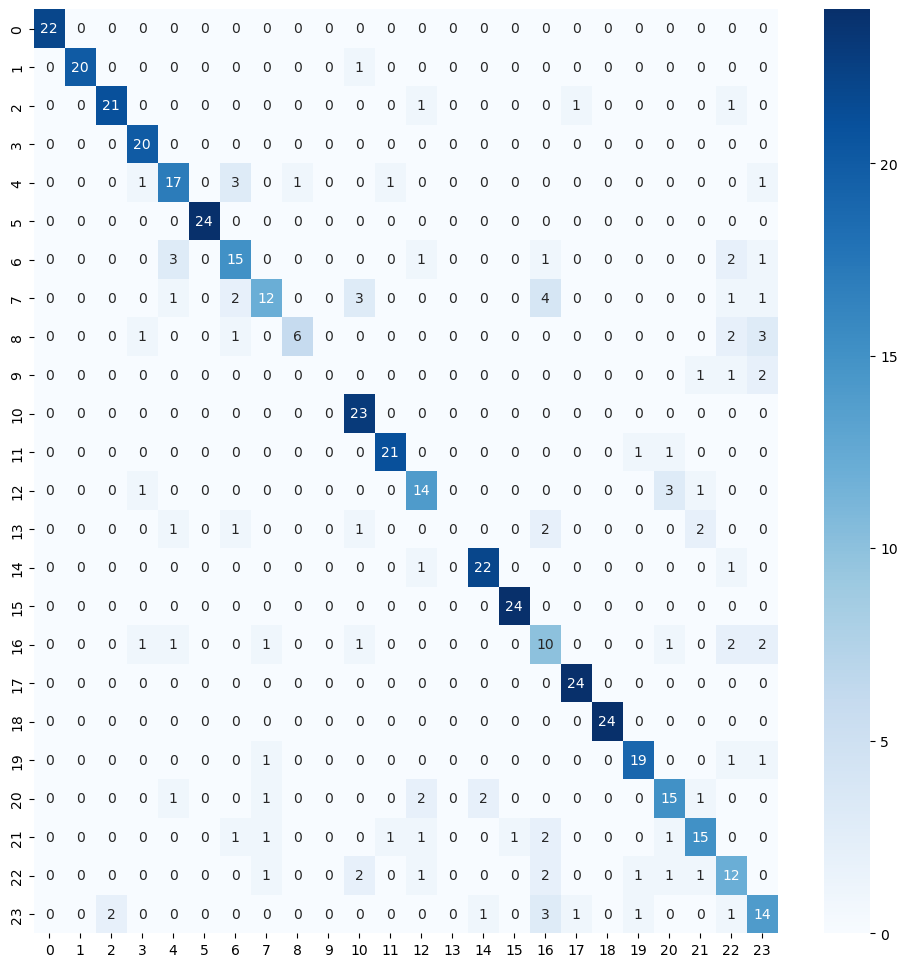

In [32]:
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()

print("Label Domains:", label_dict)

cm = confusion_matrix(labels_flat, preds_flat)

plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, cmap='Blues')